In [23]:
# ============================================
# COMPARACIÓN DE PHASENET Y EQTRANSFORMER
# PARA DETECCIÓN DE FASES SÍSMICAS
# Santiago Vilca Limachi – Segundo Avance
# ============================================
import seisbench
import seisbench.models as sbm

In [24]:
# Various pre-trained weights for PhaseNet
# pn_model = sbm.PhaseNet.from_pretrained("ethz")
# pn_model = sbm.PhaseNet.from_pretrained("instance")
# pn_model = sbm.PhaseNet.from_pretrained("scedc")
pn_model = sbm.PhaseNet.from_pretrained("stead")
# pn_model = sbm.PhaseNet.from_pretrained("geofon")
# pn_model = sbm.PhaseNet.from_pretrained("neic")

# Various pre-trained weights for EQT
eqt_model = sbm.EQTransformer.from_pretrained("original")
# eqt_model = sbm.EQTransformer.from_pretrained("ethz")
# eqt_model = sbm.EQTransformer.from_pretrained("instance")
# eqt_model = sbm.EQTransformer.from_pretrained("scedc")
# eqt_model = sbm.EQTransformer.from_pretrained("stead")
# eqt_model = sbm.EQTransformer.from_pretrained("geofon")

# Various pre-trained weights for GPD
# gpd_model = sbm.GPD.from_pretrained("original")
# gpd_model = sbm.GPD.from_pretrained("ethz")
# gpd_model = sbm.GPD.from_pretrained("scedc")
gpd_model = sbm.GPD.from_pretrained("stead")
# gpd_model = sbm.GPD.from_pretrained("geofon")
# gpd_model = sbm.GPD.from_pretrained("neic")

In [25]:
pn_model.cuda();
eqt_model.cuda();
gpd_model.cuda();

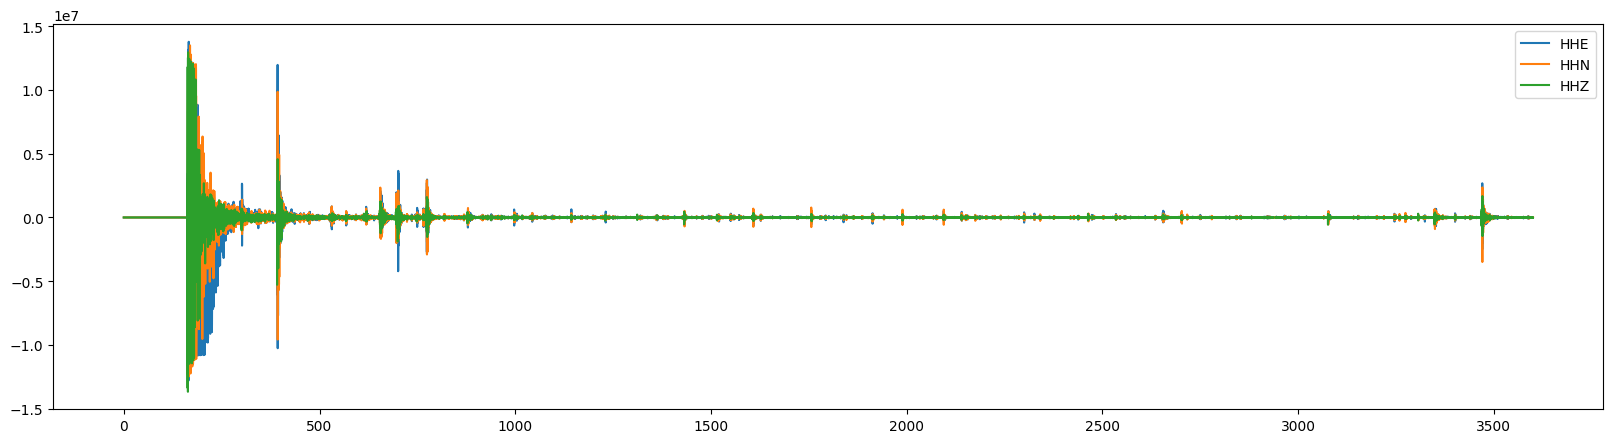

In [30]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

client = Client("INGV")

t = UTCDateTime(2009, 4, 6, 1, 30)
stream = client.get_waveforms(network="MN", station="AQU", location="*", channel="HH?", starttime=t, endtime=t+3600)


fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend();

In [31]:
pn_preds = pn_model.annotate(stream)
eqt_preds = eqt_model.annotate(stream)
gpd_preds = gpd_model.annotate(stream)

pn_preds

3 Trace(s) in Stream:
MN.AQU..PhaseNet_P | 2009-04-06T01:30:02.498597Z - 2009-04-06T02:29:57.498597Z | 100.0 Hz, 359501 samples
MN.AQU..PhaseNet_S | 2009-04-06T01:30:02.498597Z - 2009-04-06T02:29:57.498597Z | 100.0 Hz, 359501 samples
MN.AQU..PhaseNet_N | 2009-04-06T01:30:02.498597Z - 2009-04-06T02:29:57.498597Z | 100.0 Hz, 359501 samples

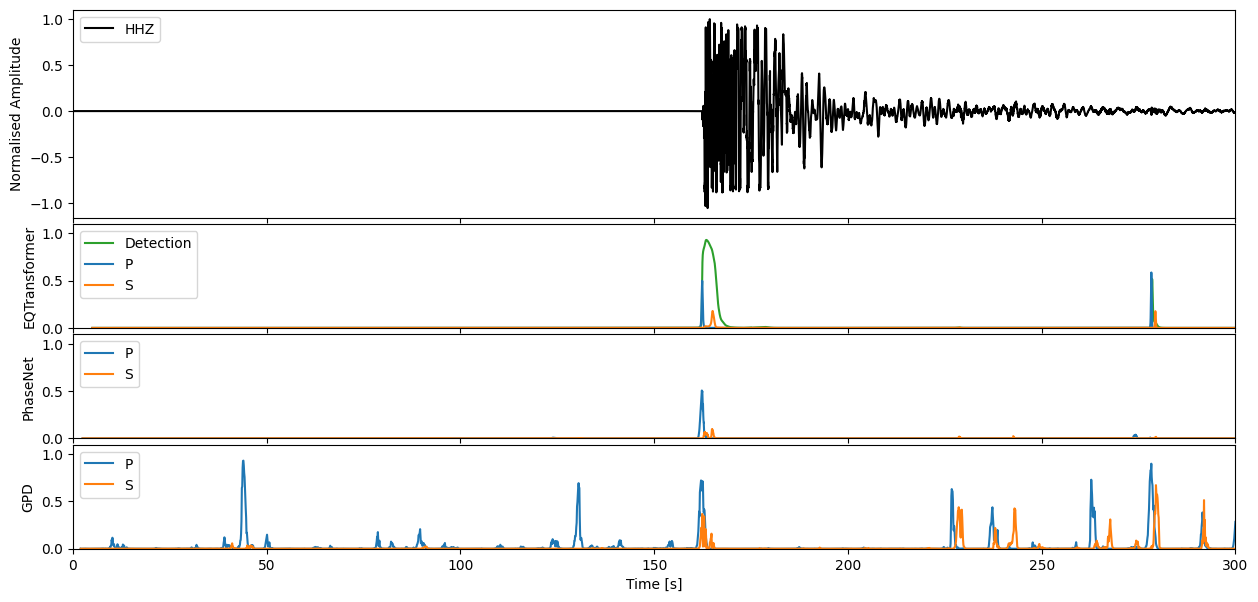

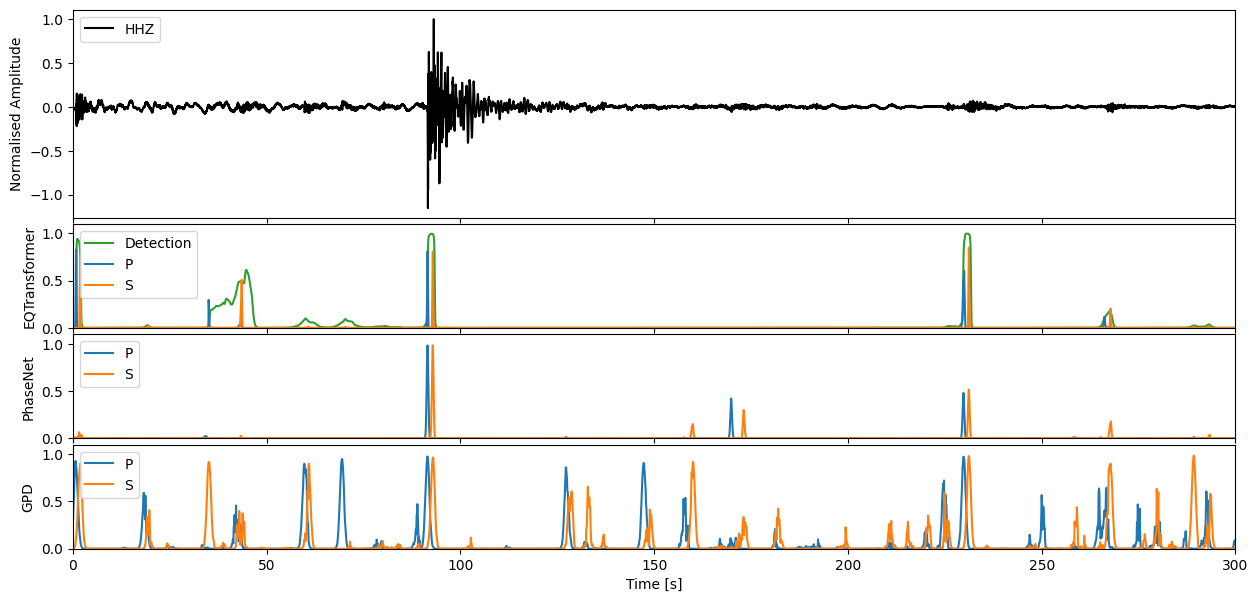

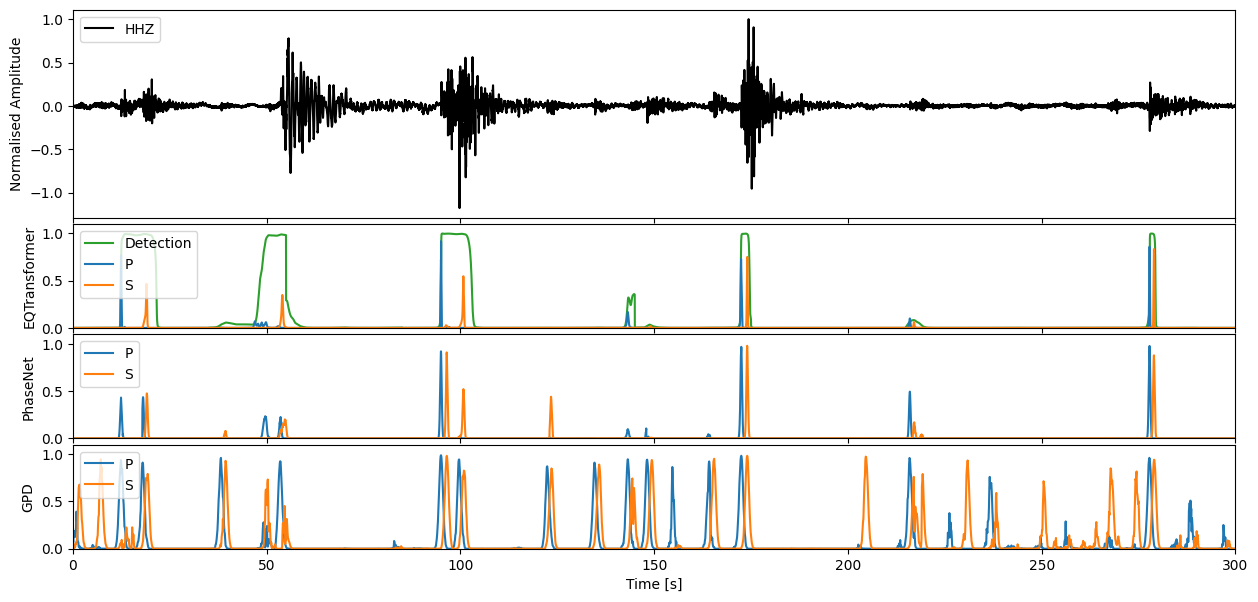

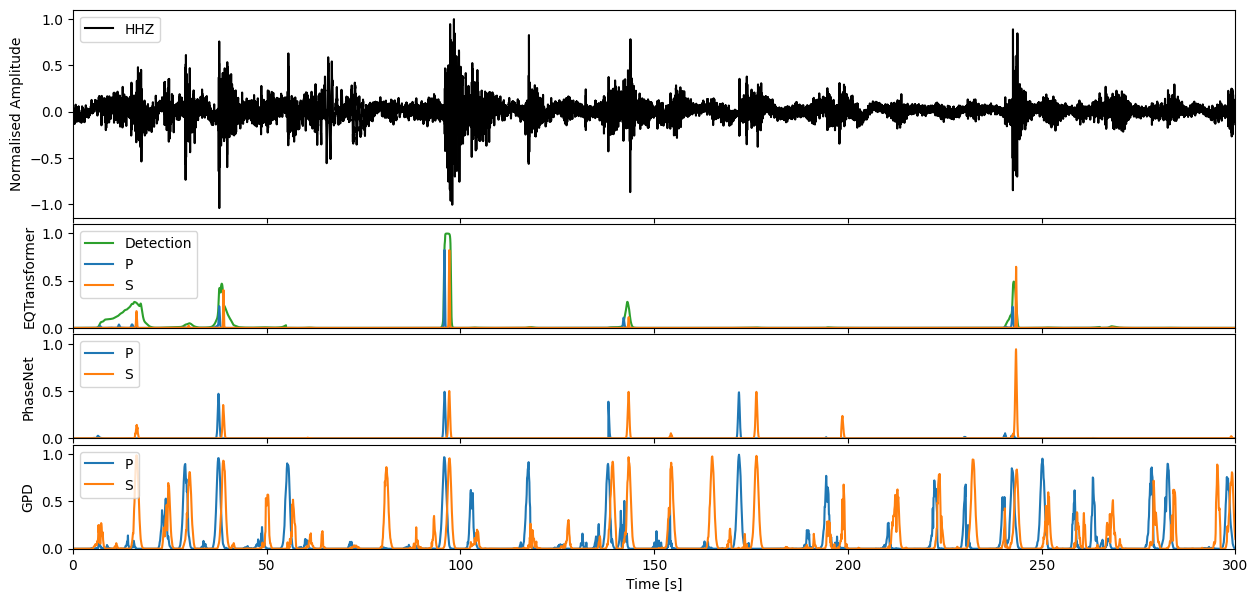

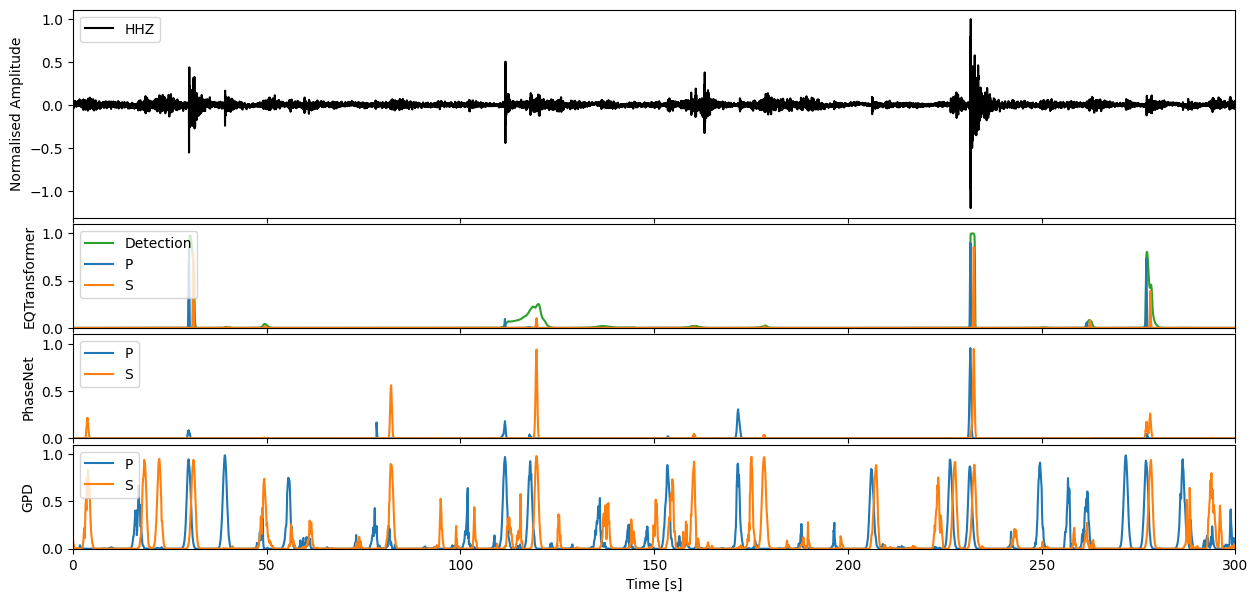

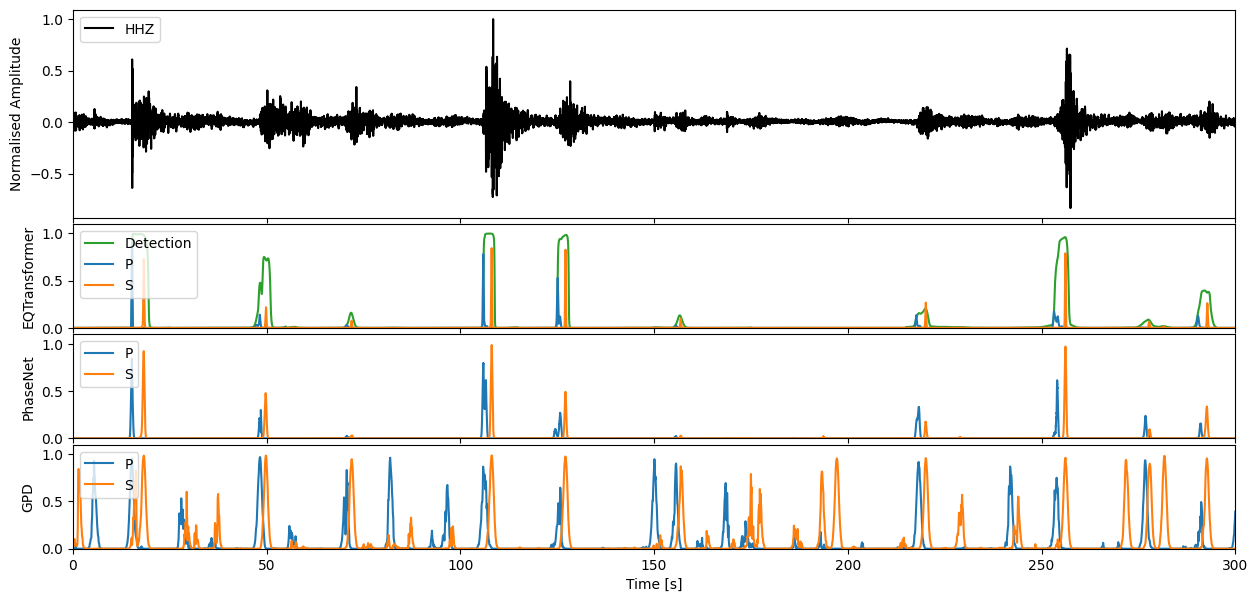

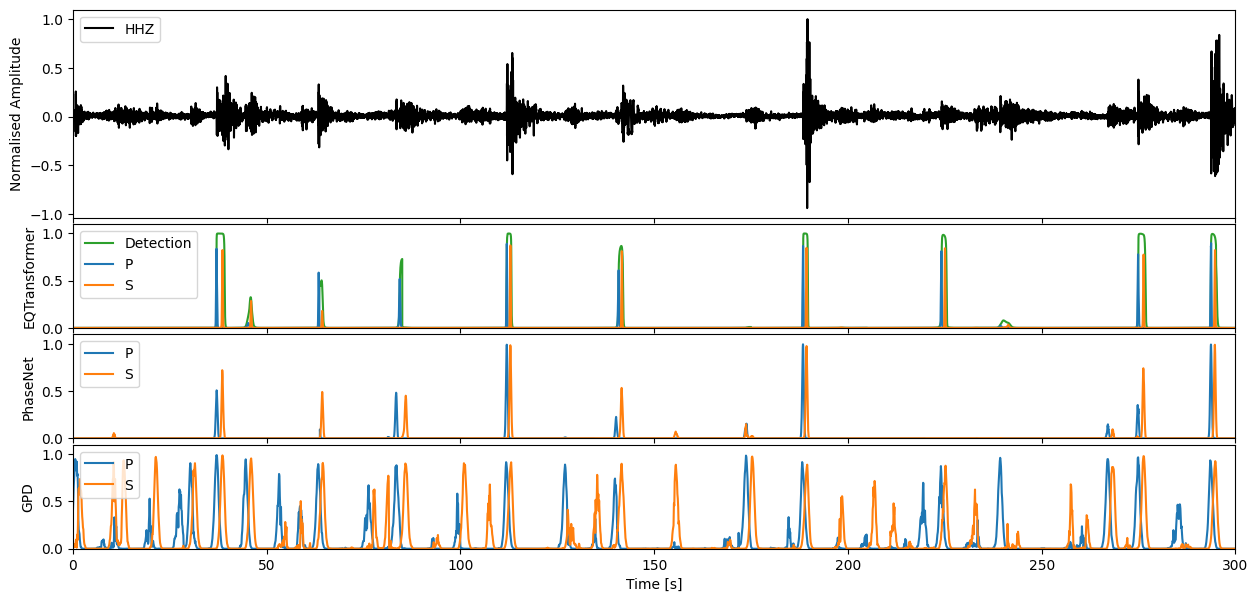

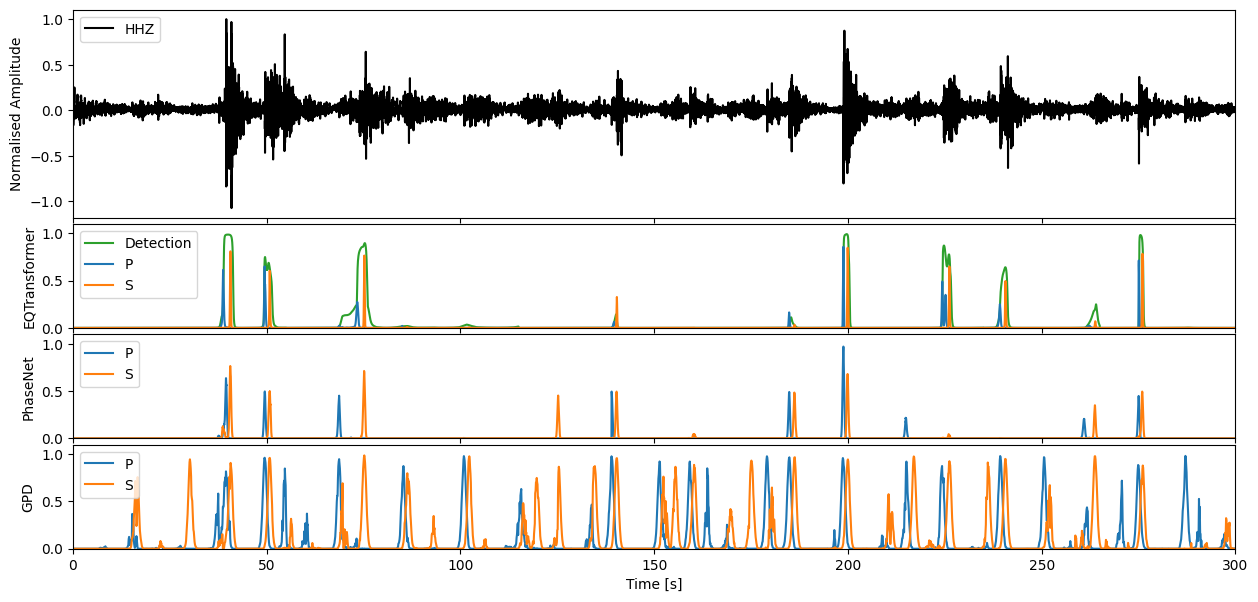

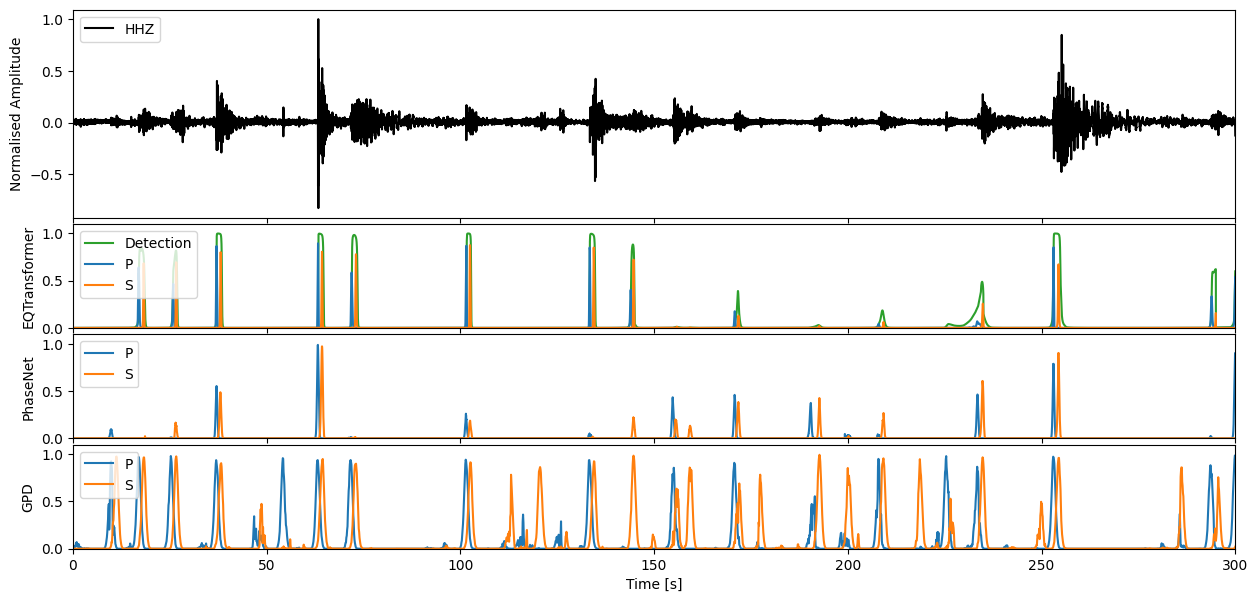

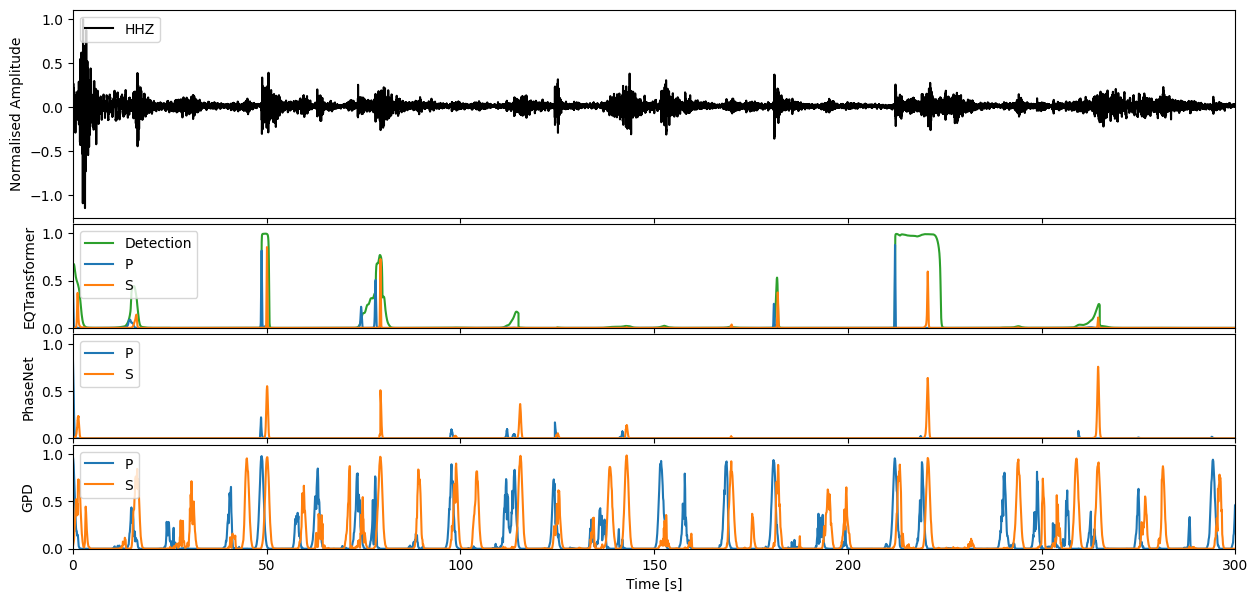

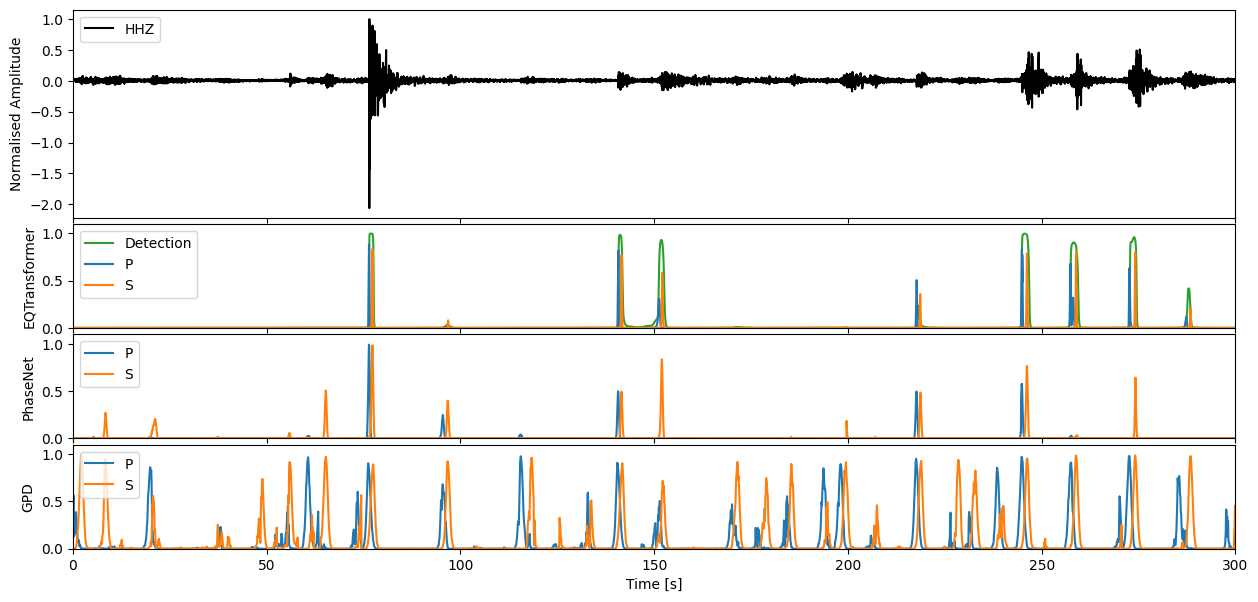

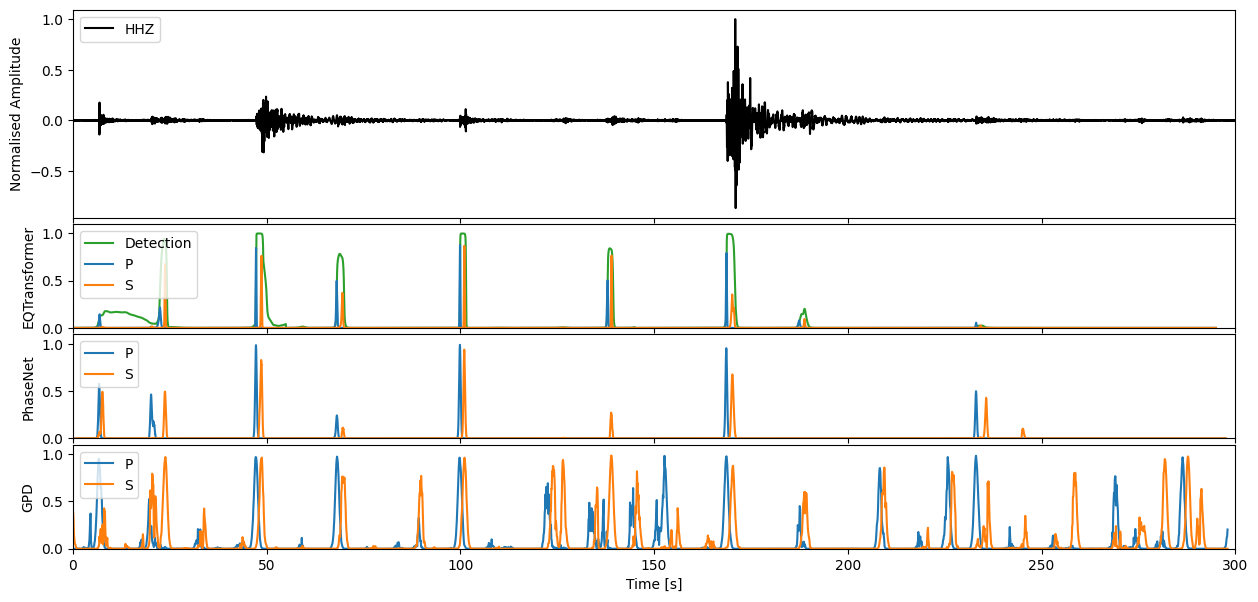

In [32]:
color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}
wlength = 5*60

for s in range(0, int(stream[0].stats.endtime - stream[0].stats.starttime), wlength):
    t0 = stream[0].stats.starttime + s
    t1 = t0 + wlength
    subst = stream.slice(t0, t1)

    fig, ax = plt.subplots(4, 1, figsize=(15, 7), sharex=True, gridspec_kw={'hspace' : 0.05, 'height_ratios': [2, 1, 1, 1]})
    
    for i, preds in enumerate([eqt_preds, pn_preds, gpd_preds]):
        subpreds = preds.slice(t0, t1)
        offset = subpreds[0].stats.starttime - subst[0].stats.starttime
        for pred_trace in subpreds:
            model, pred_class = pred_trace.stats.channel.split("_")
            if pred_class == "N":
                continue
            c = color_dict[pred_class]
            ax[i + 1].plot(offset + pred_trace.times(), pred_trace.data, label=pred_class, c=c)
        ax[i + 1].set_ylabel(model)
        ax[i + 1].legend(loc=2)
        ax[i + 1].set_ylim(0, 1.1)
    
    ax[0].plot(subst[-1].times(), subst[-1].data / np.amax(subst[-1].data), 'k', label=subst[-1].stats.channel)
    ax[0].set_xlim(0, wlength)
    ax[0].set_ylabel('Normalised Amplitude')
    ax[3].set_xlabel('Time [s]')
    ax[0].legend(loc=2)
    plt.show()